In [1]:
import numpy as np
import pandas as pd
import pickle
data = pickle.load(open('../data/60_second_data1.p','rb'))

In [2]:
from hrvanalysis import get_time_domain_features
from joblib import Parallel,delayed
data.shape

(231530, 60, 11)

In [3]:
def get_data(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>40:
        return [],[],[],[],[],[]
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.std(ecg_rr[ecg_rr>0])
    ecg_rr[np.isnan(ecg_rr)] = 0
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         index = ppg_rr>0
#         ppg_qual = ppg_qual[index]
#         ppg_rr = ppg_rr[index]
        index = np.isnan(ppg_rr)
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<10:
            continue
        ppg_qual[index] = -1
        ppg_rr[index] = np.nanmean(ppg_rr)
        y.append(ppg_rr.reshape(1,60,1))
        tmp = a[:,np.array([-2,-6,1])].reshape(1,60,3)
        tmp[np.isnan(tmp)] = 0
        tmp[tmp==0] = 0
        X.append(tmp)
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
#         for j in np.linspace(0,.9,20):
#             index = ppg_qual>j
#             ppg_qual = ppg_qual[index]
#             ppg_rr = ppg_rr[index]
#             if len(ppg_rr)<10:
#                 continue
#             f = list(get_time_domain_features(ppg_rr).values())
#             f1 = list(get_time_domain_features(ecg_rr).values())
#             q = [np.percentile(ppg_qual,20),np.median(ppg_qual),len(ppg_rr)/60]
#             features.append(np.array(f1+f+q))
    return X,y,ecg,means,stds,quals

df_col = Parallel(n_jobs=10,verbose=1)(delayed(get_data)(a) for a in data if len(a[~np.isnan(a[:,-1]),-1])>20)    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 6390 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 11756 out of 11775 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 11775 out of 11775 | elapsed:    3.2s finished


In [4]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for a in df_col:
    if len(a[0])==0:
        continue
    X.extend(a[0])
    y.extend(a[1])
    ecg.extend(a[2])
    means.extend(a[3])
    stds.extend(a[4])
    quals.extend(a[5])

In [5]:
np.concatenate(y).shape

(11775, 60, 1)

In [6]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [7]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
# import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X, y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X.shape,y.shape,y_val.shape,means_val.shape,stds_val.shape)

Using TensorFlow backend.


(11775, 60, 3) (11775, 60) (1578, 60) (1578, 1) (1578, 1)


In [8]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return K.mean(x, axis=1, keepdims=True)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return K.std(x, axis=1, keepdims=True)

timesteps = 60
input_dim = 3
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = TimeDistributed(Dense(10,activation='relu'))(mer)
encoded = Flatten()(encoded)
# encoded = Dense(10,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
# encoded = Reshape((60),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
# encoder = Model(inputs, encoded)
losses = {
    "std":"logcosh",
    "mean": "logcosh",
    "sequence": "mae"
}
lossWeights = {"mean": 1, "sequence": 1,"std":1}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 3)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 120)      23040       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 60, 1)        121         bidirectional_1[0][0]            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 60)           0           dense_1[0][0]                    
____________________________________________________________________________________________

In [9]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 6311 samples, validate on 1578 samples
Epoch 1/300
6311/6311 [==============================] - 4s 583us/step - loss: 1495.9423 - sequence_loss: 718.6205 - mean_loss: 732.9737 - std_loss: 44.1812 - val_loss: 1491.5418 - val_sequence_loss: 718.0582 - val_mean_loss: 731.6567 - val_std_loss: 41.0406

Epoch 00001: val_loss improved from inf to 1491.54178, saving model to ../models/base_LSTM.hdf5
Epoch 2/300
6311/6311 [==============================] - 3s 431us/step - loss: 1481.3672 - sequence_loss: 713.9789 - mean_loss: 727.6719 - std_loss: 39.4344 - val_loss: 1469.6340 - val_sequence_loss: 710.5925 - val_mean_loss: 723.3659 - val_std_loss: 34.9201

Epoch 00002: val_loss improved from 1491.54178 to 1469.63399, saving model to ../models/base_LSTM.hdf5
Epoch 3/300
6311/6311 [==============================] - 3s 427us/step - loss: 1434.6892 - sequence_loss: 696.3669 - mean_loss: 708.1868 - std_loss: 29.3045 - val_loss: 1381.3111 - val_sequence_loss: 675.3990 - val_mean_loss: 684.020

6311/6311 [==============================] - 3s 422us/step - loss: 297.7139 - sequence_loss: 185.6663 - mean_loss: 93.6053 - std_loss: 18.5465 - val_loss: 311.7786 - val_sequence_loss: 190.8900 - val_mean_loss: 101.2543 - val_std_loss: 18.2112

Epoch 00024: val_loss did not improve from 301.65644
Epoch 25/300
6311/6311 [==============================] - 3s 426us/step - loss: 304.9142 - sequence_loss: 187.9928 - mean_loss: 98.3290 - std_loss: 18.3349 - val_loss: 303.3624 - val_sequence_loss: 186.3321 - val_mean_loss: 96.9021 - val_std_loss: 18.3076

Epoch 00025: val_loss did not improve from 301.65644
Epoch 26/300
6311/6311 [==============================] - 3s 424us/step - loss: 299.4934 - sequence_loss: 185.9458 - mean_loss: 95.2032 - std_loss: 18.5436 - val_loss: 299.2632 - val_sequence_loss: 185.2706 - val_mean_loss: 95.3631 - val_std_loss: 18.0973

Epoch 00026: val_loss improved from 301.65644 to 299.26324, saving model to ../models/base_LSTM.hdf5
Epoch 27/300
6311/6311 [==========

6311/6311 [==============================] - 3s 425us/step - loss: 283.2199 - sequence_loss: 179.7741 - mean_loss: 85.1772 - std_loss: 18.4025 - val_loss: 288.5294 - val_sequence_loss: 182.0612 - val_mean_loss: 88.3830 - val_std_loss: 17.9684

Epoch 00048: val_loss did not improve from 285.74996
Epoch 49/300
6311/6311 [==============================] - 3s 424us/step - loss: 284.9756 - sequence_loss: 180.4409 - mean_loss: 85.9331 - std_loss: 18.2323 - val_loss: 285.6765 - val_sequence_loss: 180.3813 - val_mean_loss: 87.0473 - val_std_loss: 18.0385

Epoch 00049: val_loss improved from 285.74996 to 285.67648, saving model to ../models/base_LSTM.hdf5
Epoch 50/300
6311/6311 [==============================] - 3s 424us/step - loss: 283.3441 - sequence_loss: 179.5422 - mean_loss: 85.2309 - std_loss: 18.3037 - val_loss: 285.9280 - val_sequence_loss: 180.4241 - val_mean_loss: 86.7494 - val_std_loss: 17.9793

Epoch 00050: val_loss did not improve from 285.67648
Epoch 51/300
6311/6311 [===========

6311/6311 [==============================] - 3s 426us/step - loss: 283.8384 - sequence_loss: 179.8318 - mean_loss: 85.5326 - std_loss: 18.3526 - val_loss: 286.0151 - val_sequence_loss: 180.4615 - val_mean_loss: 86.9448 - val_std_loss: 18.0341

Epoch 00073: val_loss did not improve from 283.72830
Epoch 74/300
6311/6311 [==============================] - 3s 428us/step - loss: 282.3818 - sequence_loss: 179.3827 - mean_loss: 84.7375 - std_loss: 18.3883 - val_loss: 286.0567 - val_sequence_loss: 180.5558 - val_mean_loss: 87.2303 - val_std_loss: 18.0861

Epoch 00074: val_loss did not improve from 283.72830
Epoch 75/300
6311/6311 [==============================] - 3s 422us/step - loss: 281.8986 - sequence_loss: 179.1207 - mean_loss: 84.1027 - std_loss: 18.3056 - val_loss: 284.8086 - val_sequence_loss: 180.7938 - val_mean_loss: 85.3158 - val_std_loss: 18.3531

Epoch 00075: val_loss did not improve from 283.72830
Epoch 76/300
6311/6311 [==============================] - 3s 420us/step - loss: 281

6311/6311 [==============================] - 3s 419us/step - loss: 280.8751 - sequence_loss: 178.7746 - mean_loss: 83.9901 - std_loss: 18.2045 - val_loss: 283.6546 - val_sequence_loss: 179.9526 - val_mean_loss: 85.4922 - val_std_loss: 18.0403

Epoch 00099: val_loss did not improve from 283.17534
Epoch 100/300
6311/6311 [==============================] - 3s 423us/step - loss: 280.1057 - sequence_loss: 178.7007 - mean_loss: 83.4282 - std_loss: 18.2548 - val_loss: 284.1498 - val_sequence_loss: 179.9516 - val_mean_loss: 86.0548 - val_std_loss: 18.1173

Epoch 00100: val_loss did not improve from 283.17534
Epoch 101/300
6311/6311 [==============================] - 3s 424us/step - loss: 280.8277 - sequence_loss: 178.8231 - mean_loss: 83.8569 - std_loss: 18.3304 - val_loss: 283.7214 - val_sequence_loss: 180.3890 - val_mean_loss: 85.3005 - val_std_loss: 17.9165

Epoch 00101: val_loss did not improve from 283.17534
Epoch 102/300
6311/6311 [==============================] - 3s 419us/step - loss: 


Epoch 00124: val_loss did not improve from 281.76657
Epoch 125/300
6311/6311 [==============================] - 3s 419us/step - loss: 277.9420 - sequence_loss: 177.6682 - mean_loss: 81.8454 - std_loss: 18.4982 - val_loss: 281.8843 - val_sequence_loss: 179.1666 - val_mean_loss: 83.1265 - val_std_loss: 18.3207

Epoch 00125: val_loss did not improve from 281.76657
Epoch 126/300
6311/6311 [==============================] - 3s 424us/step - loss: 278.1906 - sequence_loss: 177.8281 - mean_loss: 81.9296 - std_loss: 18.3788 - val_loss: 280.7865 - val_sequence_loss: 178.9874 - val_mean_loss: 82.6438 - val_std_loss: 18.2099

Epoch 00126: val_loss improved from 281.76657 to 280.78650, saving model to ../models/base_LSTM.hdf5
Epoch 127/300
6311/6311 [==============================] - 3s 419us/step - loss: 279.5886 - sequence_loss: 178.4267 - mean_loss: 82.8405 - std_loss: 18.4979 - val_loss: 284.7906 - val_sequence_loss: 180.4183 - val_mean_loss: 84.7762 - val_std_loss: 18.3704

Epoch 00127: val_l


Epoch 00150: val_loss did not improve from 280.27603
Epoch 151/300
6311/6311 [==============================] - 3s 421us/step - loss: 275.8029 - sequence_loss: 175.5334 - mean_loss: 80.7968 - std_loss: 19.3526 - val_loss: 281.5837 - val_sequence_loss: 178.0850 - val_mean_loss: 83.0161 - val_std_loss: 19.5531

Epoch 00151: val_loss did not improve from 280.27603
Epoch 152/300
6311/6311 [==============================] - 3s 423us/step - loss: 276.5635 - sequence_loss: 175.9501 - mean_loss: 81.0045 - std_loss: 19.5405 - val_loss: 279.8857 - val_sequence_loss: 176.7364 - val_mean_loss: 82.5514 - val_std_loss: 19.8085

Epoch 00152: val_loss improved from 280.27603 to 279.88573, saving model to ../models/base_LSTM.hdf5
Epoch 153/300
6311/6311 [==============================] - 3s 421us/step - loss: 275.7614 - sequence_loss: 175.6906 - mean_loss: 80.3322 - std_loss: 19.3975 - val_loss: 280.5051 - val_sequence_loss: 177.4435 - val_mean_loss: 82.8014 - val_std_loss: 19.8224

Epoch 00153: val_l

6311/6311 [==============================] - 3s 426us/step - loss: 270.6001 - sequence_loss: 168.3547 - mean_loss: 80.9062 - std_loss: 20.8246 - val_loss: 274.1126 - val_sequence_loss: 169.4233 - val_mean_loss: 83.7934 - val_std_loss: 20.9233

Epoch 00175: val_loss did not improve from 272.38538
Epoch 176/300
6311/6311 [==============================] - 3s 425us/step - loss: 266.8765 - sequence_loss: 166.7014 - mean_loss: 80.2663 - std_loss: 20.0895 - val_loss: 269.4839 - val_sequence_loss: 168.1924 - val_mean_loss: 81.6666 - val_std_loss: 19.2674

Epoch 00176: val_loss improved from 272.38538 to 269.48390, saving model to ../models/base_LSTM.hdf5
Epoch 177/300
6311/6311 [==============================] - 3s 419us/step - loss: 265.6633 - sequence_loss: 166.0076 - mean_loss: 80.2391 - std_loss: 19.7043 - val_loss: 269.3495 - val_sequence_loss: 166.5110 - val_mean_loss: 81.4105 - val_std_loss: 20.9002

Epoch 00177: val_loss improved from 269.48390 to 269.34945, saving model to ../models/


Epoch 00199: val_loss did not improve from 261.25880
Epoch 200/300
6311/6311 [==============================] - 3s 424us/step - loss: 257.9044 - sequence_loss: 157.6767 - mean_loss: 79.7217 - std_loss: 20.5984 - val_loss: 261.1854 - val_sequence_loss: 157.9287 - val_mean_loss: 81.7819 - val_std_loss: 21.2830

Epoch 00200: val_loss improved from 261.25880 to 261.18544, saving model to ../models/base_LSTM.hdf5
Epoch 201/300
6311/6311 [==============================] - 3s 419us/step - loss: 258.4255 - sequence_loss: 157.4594 - mean_loss: 79.8409 - std_loss: 21.0370 - val_loss: 262.1691 - val_sequence_loss: 158.8581 - val_mean_loss: 81.4783 - val_std_loss: 21.5317

Epoch 00201: val_loss did not improve from 261.18544
Epoch 202/300
6311/6311 [==============================] - 3s 420us/step - loss: 256.6926 - sequence_loss: 156.8784 - mean_loss: 79.4853 - std_loss: 20.3666 - val_loss: 259.8347 - val_sequence_loss: 157.0556 - val_mean_loss: 80.9717 - val_std_loss: 21.3914

Epoch 00202: val_l

6311/6311 [==============================] - 3s 425us/step - loss: 250.0879 - sequence_loss: 149.8971 - mean_loss: 78.8976 - std_loss: 21.4369 - val_loss: 253.0996 - val_sequence_loss: 151.2175 - val_mean_loss: 80.5175 - val_std_loss: 21.0192

Epoch 00224: val_loss improved from 254.31544 to 253.09956, saving model to ../models/base_LSTM.hdf5
Epoch 225/300
6311/6311 [==============================] - 3s 419us/step - loss: 249.2491 - sequence_loss: 149.0018 - mean_loss: 78.8175 - std_loss: 21.6602 - val_loss: 256.8150 - val_sequence_loss: 153.0975 - val_mean_loss: 79.9946 - val_std_loss: 23.1833

Epoch 00225: val_loss did not improve from 253.09956
Epoch 226/300
6311/6311 [==============================] - 3s 424us/step - loss: 258.6620 - sequence_loss: 154.4383 - mean_loss: 79.8420 - std_loss: 24.8504 - val_loss: 261.1710 - val_sequence_loss: 155.2992 - val_mean_loss: 80.6877 - val_std_loss: 24.6634

Epoch 00226: val_loss did not improve from 253.09956
Epoch 227/300
6311/6311 [========

6311/6311 [==============================] - 3s 417us/step - loss: 246.4485 - sequence_loss: 143.8139 - mean_loss: 78.9229 - std_loss: 23.9391 - val_loss: 249.0284 - val_sequence_loss: 142.8843 - val_mean_loss: 80.0049 - val_std_loss: 25.3861

Epoch 00249: val_loss improved from 249.37543 to 249.02841, saving model to ../models/base_LSTM.hdf5
Epoch 250/300
6311/6311 [==============================] - 3s 423us/step - loss: 246.9714 - sequence_loss: 144.0703 - mean_loss: 78.6993 - std_loss: 24.1008 - val_loss: 249.1712 - val_sequence_loss: 147.0473 - val_mean_loss: 79.7418 - val_std_loss: 21.8011

Epoch 00250: val_loss did not improve from 249.02841
Epoch 251/300
6311/6311 [==============================] - 3s 421us/step - loss: 245.8731 - sequence_loss: 143.7035 - mean_loss: 78.4779 - std_loss: 23.7459 - val_loss: 248.3536 - val_sequence_loss: 145.0772 - val_mean_loss: 80.0488 - val_std_loss: 22.6684

Epoch 00251: val_loss improved from 249.02841 to 248.35355, saving model to ../models/

6311/6311 [==============================] - 3s 422us/step - loss: 244.4263 - sequence_loss: 141.0149 - mean_loss: 78.8579 - std_loss: 25.2888 - val_loss: 245.8153 - val_sequence_loss: 141.6890 - val_mean_loss: 79.2392 - val_std_loss: 24.0033

Epoch 00274: val_loss improved from 246.02595 to 245.81535, saving model to ../models/base_LSTM.hdf5
Epoch 275/300
6311/6311 [==============================] - 3s 421us/step - loss: 242.6894 - sequence_loss: 139.8604 - mean_loss: 78.3294 - std_loss: 24.6975 - val_loss: 245.6250 - val_sequence_loss: 139.4969 - val_mean_loss: 79.3714 - val_std_loss: 25.7622

Epoch 00275: val_loss improved from 245.81535 to 245.62504, saving model to ../models/base_LSTM.hdf5
Epoch 276/300
6311/6311 [==============================] - 3s 424us/step - loss: 241.8401 - sequence_loss: 139.1731 - mean_loss: 77.9857 - std_loss: 24.9059 - val_loss: 245.8065 - val_sequence_loss: 142.8799 - val_mean_loss: 79.2044 - val_std_loss: 22.8206

Epoch 00276: val_loss did not improve 


Epoch 00299: val_loss did not improve from 244.47515
Epoch 300/300
6311/6311 [==============================] - 3s 421us/step - loss: 242.4334 - sequence_loss: 137.6183 - mean_loss: 78.4911 - std_loss: 26.3476 - val_loss: 245.3286 - val_sequence_loss: 137.0317 - val_mean_loss: 79.1638 - val_std_loss: 27.9912

Epoch 00300: val_loss did not improve from 244.47515


In [10]:
from keras.models import load_model
sequence_autoencoder = load_model(filepath)

In [11]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [12]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((3886, 60), (3886, 1), (3886, 1))

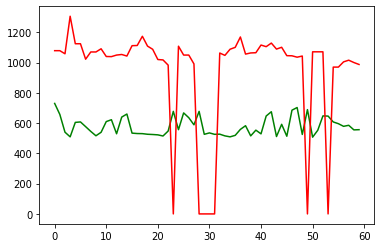

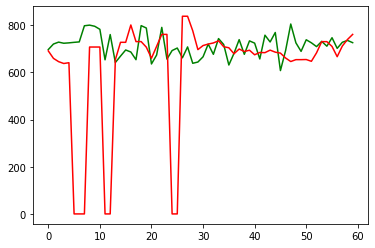

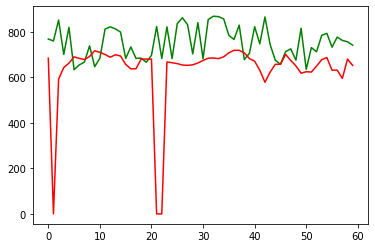

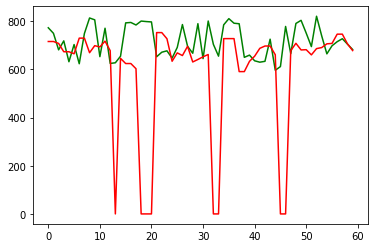

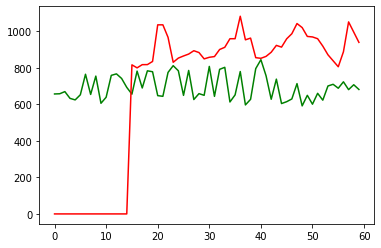

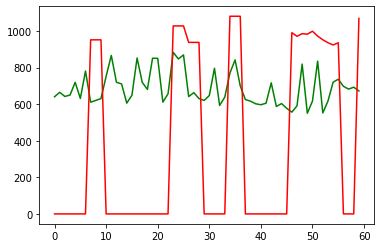

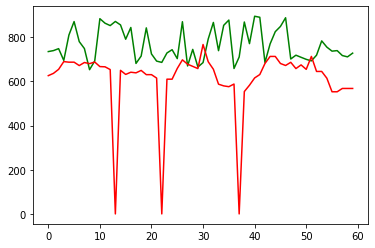

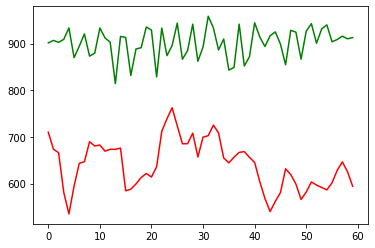

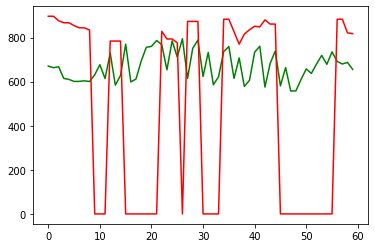

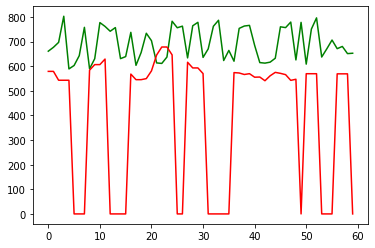

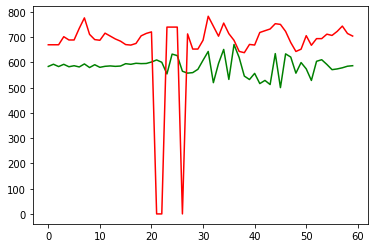

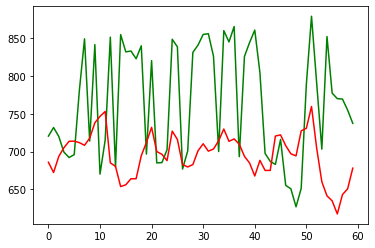

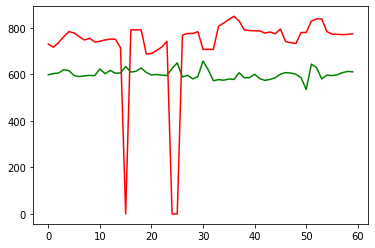

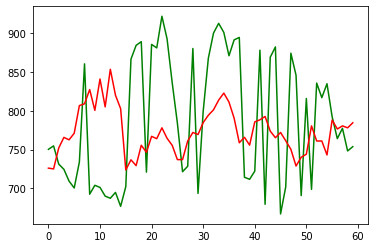

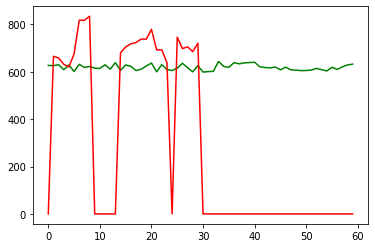

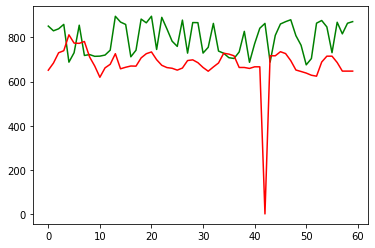

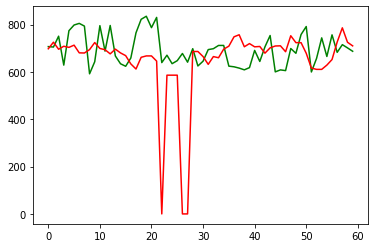

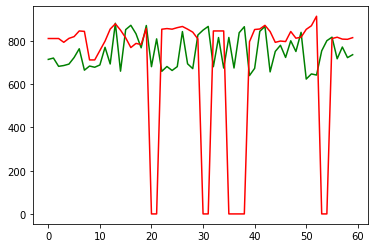

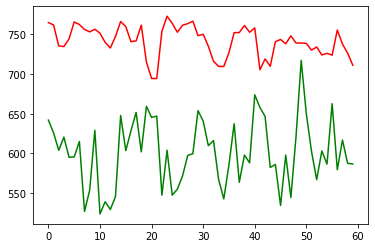

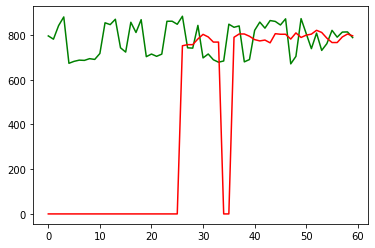

In [13]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[::-1][20:40]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#         plt.plot(X[i,:,:],'r')
#     plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [14]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [15]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]

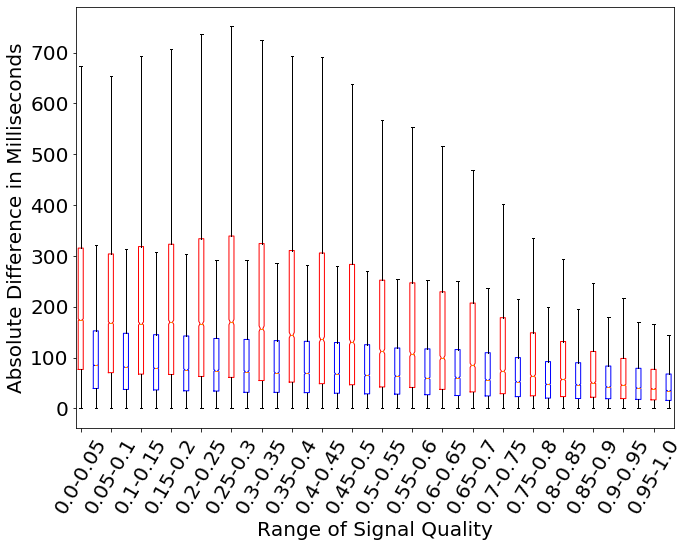

In [16]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    y1.append(list(np.abs(temp[:,1]-temp[:,2])))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [29]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [30]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

(0.06266206183824703, 0.02413317513241004) (0.020633998683455387, 0.4581483841357953) 0.0 0.1 1295
(0.15287968385454784, 9.435967813540757e-07) (0.0855662503153064, 0.00627435239660266) 0.1 0.2 1019
(0.21750419114023226, 2.900210838540958e-06) (0.06577854684919399, 0.16174895685785776) 0.2 0.30000000000000004 454
(0.10072127202990576, 0.09925966448753634) (0.14229747459005476, 0.01954981734608852) 0.30000000000000004 0.4 269
(0.2886244938813999, 5.6334659678148885e-05) (-0.050620163561838134, 0.48910113848016445) 0.4 0.5 189
(0.3167104629623304, 0.00021574620884079853) (0.02062743697816771, 0.8143933767237532) 0.5 0.6 132
(0.41639807845491245, 1.100063561992706e-05) (0.22915793053110353, 0.01928655066989365) 0.6000000000000001 0.7000000000000001 104
(0.2507617560335644, 0.01062323724081899) (0.011280593141026276, 0.9099577004291776) 0.7000000000000001 0.8 103
(0.13916495400627352, 0.14706782460344842) (0.012351839853320975, 0.8980918495758908) 0.8 0.9 110
(0.26735490754371094, 6.649704

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape